# **FEATURE ENGINEERING FOR CLUSTERING**


---

The goal of this notebook is to experiment some different feature engineering techniques to perform clustering. We will use K-Means++ algorithm and the famous California Housing Price dataset available on Kaggle (https://www.kaggle.com/camnugent/california-housing-prices).

We will start with a basic clustering on the raw data and perform some experiments after doing EDA. We will evaluate our clusters solutions looking at Distortion, Inertia and Silhouette scores for different number of clusters k, and we will also look at the consequencies of our feature engineering techniques plotting the scatter matrix, a 3D scatterplot on PCA dimensions, and some histograms.

We conducted 3 experiments:
1.   Clustering on raw data
2.   Clustering on PCA over raw data
1.   Clustering after feature engineering with two different attempts to transform latitude and longitude.

If you want to try the best model, import libraries, load the dataset, run all the functions, fill missing data (EDA), and run Experiment 3 using the 2nd featurization.

If you want to try the clustering on raw data, import libraries, load the dataset, run the functions and run Experiment 1.

 



## Importing libraries

In [1]:
from google.colab import drive
import pandas as pd
import sklearn
import time
import math
from sklearn.cluster import KMeans 
from sklearn import metrics 
from scipy.spatial.distance import cdist 
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MinMaxScaler
from sklearn.ensemble import IsolationForest
from numpy import quantile, where, random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Loading the dataset

**housingMedianAge**: Median age of a house within a block; a lower number is a newer building

**population**: Total number of people residing within a block

**households**: Total number of households, a group of people residing within a home unit, for a block

**medianIncome**: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

**medianHouseValue**: Median house value for households within a block (measured in US Dollars)

**oceanProximity**: Location of the house w.r.t ocean/sea

In [ ]:
#Upload csv dataset from Drive (this dataset describes houses)
drive.mount('/content/drive')

raw_df = pd.read_csv(r'drive/MyDrive/housing.csv', sep=',' )

print("Shape: ", raw_df.shape) #looking at the dimensionality
raw_df.head(5)

Mounted at /content/drive
Shape:  (20640, 10)


longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]

## Functions

### Elbow method

to find the optimal number of clusters

In [ ]:
#X is a dataframe
def elbow(dataframe, max_k):
  distortions = [] 
  inertias = [] 
  silhouette = []
  models = []
  mapping1 = {} 
  mapping2 = {} 
  mapping3 = {}
  K = range(2,max_k) 
  
  for k in K: 
    #Building and fitting the model 
    t0 = time.time()
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=1000)
    kmeanModel.fit(dataframe)     
    t_ = time.time() - t0
    
    models.append(kmeanModel)
    distortions.append(sum(np.min(cdist(dataframe, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / dataframe.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
    silhouette.append(silhouette_score(dataframe, kmeanModel.labels_))
  
    mapping1[k] = sum(np.min(cdist(dataframe, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / dataframe.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    mapping3[k] = silhouette_score(dataframe, kmeanModel.labels_)

    print("Time needed to compute ", k, " clusters: ", t_)

  for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

  plt.plot(K, distortions, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('Distortion') 
  plt.title('The Elbow Method using Distortion') 
  plt.axis(xmin=0, ymin=0)
  plt.show() 

  for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

  plt.plot(K, inertias, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('Inertia') 
  plt.title('The Elbow Method using Inertia') 
  plt.axis(xmin=0, ymin=0)
  plt.show() 

  for key,val in mapping3.items(): 
    print(str(key)+' : '+str(val)) 

  plt.plot(K, silhouette, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('Silhouette') 
  plt.title('Silhouette score') 
  plt.axis(xmin=0, ymin=0)
  plt.show() 

  return models


To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion.

### Kmeans model information

In [ ]:
def kmeans_model_info(model,dataframe):
  print("Number of clusters: ", model.n_clusters)
  print("\nCenters:\n ", model.cluster_centers_,"\n")

  db1_labels = model.labels_
  labels, counts = np.unique(db1_labels[db1_labels>=0], return_counts=True)
  for i in range(model.n_clusters):
    print("|Cluster ",labels[i], "|: ", counts[i] )
  

  silhouette_avg = silhouette_score(dataframe, model.labels_)
  inertia = model.inertia_
  distortion = sum(np.min(cdist(dataframe, model.cluster_centers_, 
                                'euclidean'),axis=1)) / dataframe.shape[0]

  print("\nSilhouette score average: ", silhouette_avg )
  print("Inertia: ", inertia)
  print("Distortion: ", distortion)



### 2D and 3D Scatterplot with centroids

In [ ]:
def scatter_plot_3d(dataframe, model):
  fig = plt.figure(1, figsize=(6, 6))
  centers = kmeanModel.cluster_centers_

  ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
  ax.scatter(centers[:, 0], centers[:, 1], centers[:,2], s=500, marker="*",  c='black', alpha=0.5)
  ax.scatter(dataframe.loc[:, 0], dataframe.loc[:, 1], dataframe.loc[:, 2], c=model.labels_)
  plt.title("Plotting clusters in 3D")
 

  plt.show()



In [ ]:
#Given the indices of two columns, we scatterplot in those 2 dimensions; 
# the different colors represent different clusters;
# the star represents the centroid of the cluster

def scatter_plot(df, kmeanModel, dim1, dim2):

  centers = kmeanModel.cluster_centers_

  plt.figure(figsize=(20, 20))
  plt.subplot(221)
  if (isinstance(df, np.ndarray)):
    plt.scatter(df[:, dim1], df[:, dim2], c=kmeanModel.labels_, s=20)
    plt.title("Plotting points with PCA")
  else:
    plt.scatter(df.iloc[:, dim1], df.iloc[:, dim2], c=kmeanModel.labels_, s=20)
    plt.title("Plotting points in 2 dimensions")
    plt.xlabel(df.columns[dim1])
    plt.ylabel(df.columns[dim2])

  plt.scatter(centers[:, dim1], centers[:, dim2], marker="*", c='black', s=200, alpha=0.5)
  plt.show()


## Experiment 1: K-MEANS++ ON RAW DATA

In [ ]:
X = raw_df
le = preprocessing.LabelEncoder()
X['ocean_proximity'] = le.fit_transform(X['ocean_proximity'])
print(X.head(5))
np.any(np.isnan(X)) #true
#np.all(np.isfinite(df)) #false
X = X.dropna() #drop Nan values
np.any(np.isnan(X)) #now it's false

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0                3
1    -122.22     37.86  ...            358500.0                3
2    -122.24     37.85  ...            352100.0                3
3    -122.25     37.85  ...            341300.0                3
4    -122.25     37.85  ...            342200.0                3

[5 rows x 10 columns]


False

**Applying Elbow Method** to find the optimal number of clusters.

Time needed to compute  2  clusters:  0.26204824447631836
Time needed to compute  3  clusters:  0.44810914993286133
Time needed to compute  4  clusters:  0.5216290950775146
Time needed to compute  5  clusters:  0.461536169052124
Time needed to compute  6  clusters:  0.9839363098144531
Time needed to compute  7  clusters:  0.9652183055877686
Time needed to compute  8  clusters:  0.8669486045837402
Time needed to compute  9  clusters:  1.1730210781097412
Time needed to compute  10  clusters:  0.8951418399810791
Time needed to compute  11  clusters:  1.3799505233764648
Time needed to compute  12  clusters:  1.2883317470550537
Time needed to compute  13  clusters:  1.2506074905395508
Time needed to compute  14  clusters:  1.2623815536499023
2 : 54123.94015287032
3 : 37033.97058402904
4 : 27618.750383847982
5 : 20798.35380239715
6 : 17595.907235041057
7 : 15022.811630290678
8 : 13212.671431169947
9 : 11406.931281016366
10 : 10255.593030446133
11 : 9390.088769950355
12 : 8737.815210948984
13

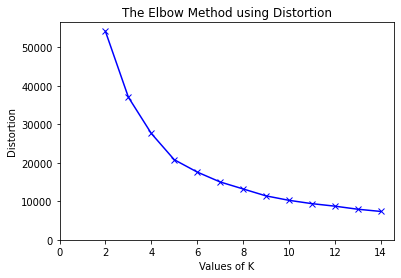

2 : 85915494844330.05
3 : 39094073748366.445
4 : 21309136361643.34
5 : 12387630113862.666
6 : 8825310574477.072
7 : 6537731441024.425
8 : 4960601313050.56
9 : 3808248745254.6304
10 : 3165392300167.9355
11 : 2581100298643.275
12 : 2189748829243.6235
13 : 1864166447151.4368
14 : 1591765484987.0193


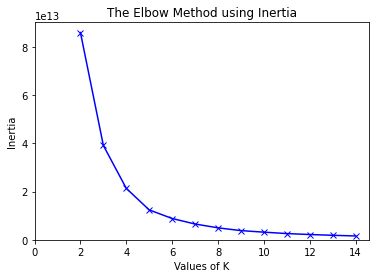

2 : 0.6285754570698812
3 : 0.5680676951774305
4 : 0.5603181384008715
5 : 0.5773225770617633
6 : 0.553504913085726
7 : 0.5471196007818567
8 : 0.5503208350172598
9 : 0.5459608774476161
10 : 0.5406897749756631
11 : 0.5408088255178575
12 : 0.5376832826641633
13 : 0.5379886013590577
14 : 0.5378959246148746


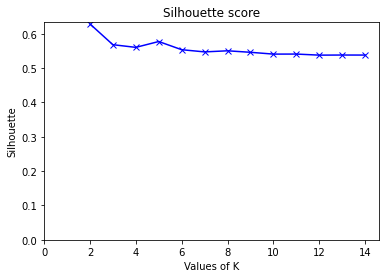

In [ ]:
models = elbow(X,15)

In [ ]:
k = 5
kmeanModel = models[k-2] #k-2 is the correct index because we started with k=2
kmeans_model_info(kmeanModel,X)


Number of clusters:  5

Centers:
  [[-1.19237249e+02  3.52713547e+01  2.74807573e+01  2.59589634e+03
   5.52972843e+02  1.56375621e+03  5.13691496e+02  3.46375175e+00
   1.64372703e+05  1.00403476e+00]
 [-1.19891355e+02  3.54739630e+01  3.01424269e+01  3.06446213e+03
   5.67614888e+02  1.37936360e+03  5.35248709e+02  5.24255047e+00
   3.46726635e+05  1.39802065e+00]
 [-1.19689186e+02  3.64223267e+01  2.81933673e+01  2.17820969e+03
   4.75745569e+02  1.29501334e+03  4.31676434e+02  2.50083351e+00
   8.98878744e+04  1.17424109e+00]
 [-1.19752688e+02  3.52907200e+01  3.33165736e+01  2.95171074e+03
   5.15082557e+02  1.15735258e+03  4.80004345e+02  7.01173706e+00
   4.80503950e+05  1.51955307e+00]
 [-1.19664355e+02  3.53555685e+01  2.84488674e+01  2.92191071e+03
   5.83784473e+02  1.50526501e+03  5.50819002e+02  4.34689136e+00
   2.45113701e+05  1.14295140e+00]] 

|Cluster  0 |:  6434
|Cluster  1 |:  2324
|Cluster  2 |:  5709
|Cluster  3 |:  1612
|Cluster  4 |:  4546

Silhouette score aver

**ScatterMatrix** considering scatterplots of all pairs of dimensions in the feature vector.

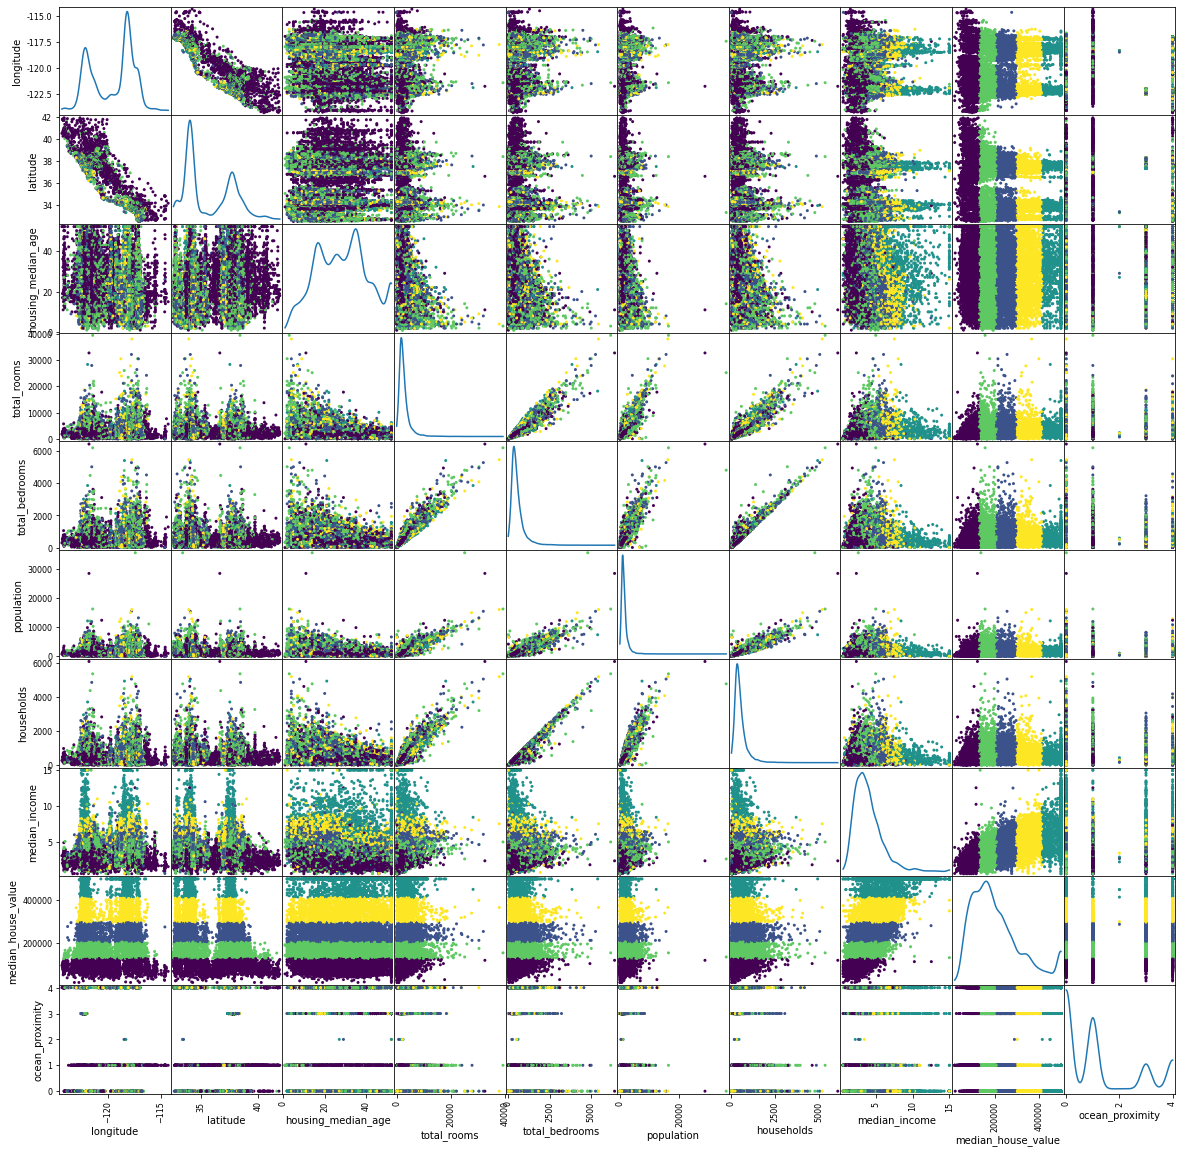

In [ ]:
ax = pd.plotting.scatter_matrix(X, alpha=1, figsize = [20, 20], c=kmeanModel.labels_, diagonal='kde')

From the plot it seems that the kmeans is clustering just considering value ranges of median_house_value. This probably happens because data has to be normalized: median_house_values are really higher with respect to all the other values and bias the results.

**Plotting distributions of features in the clusters with histograms**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


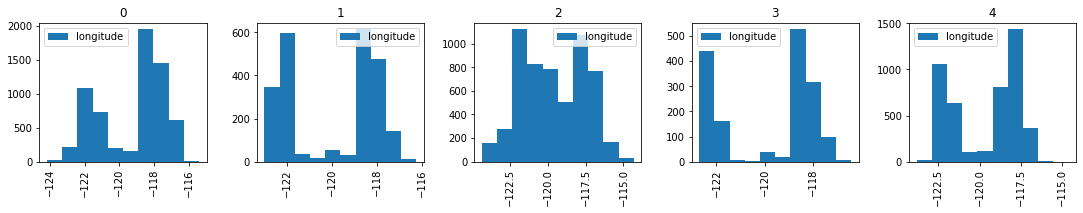

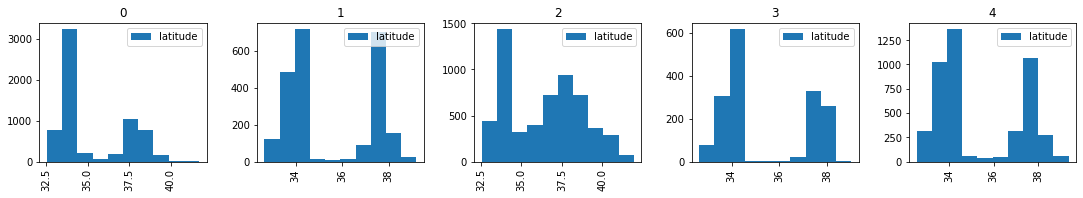

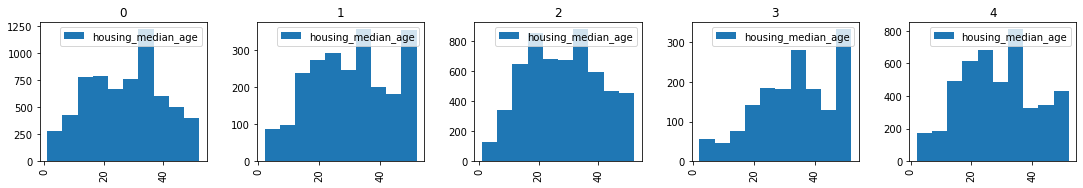

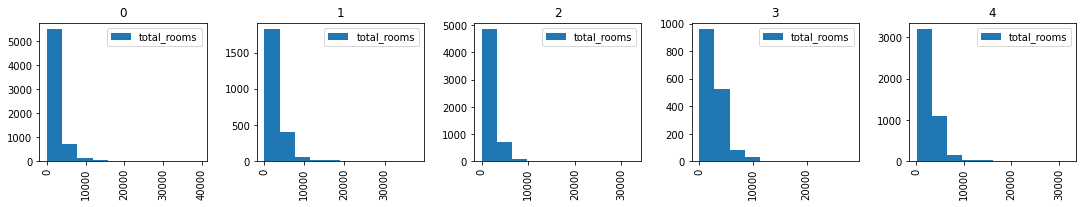

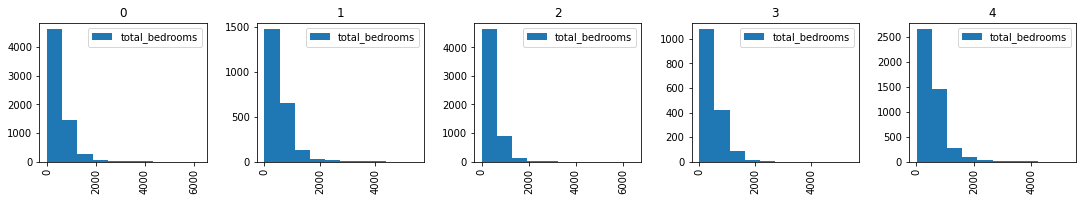

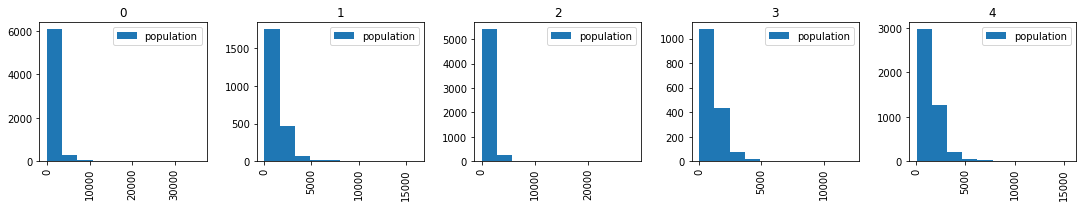

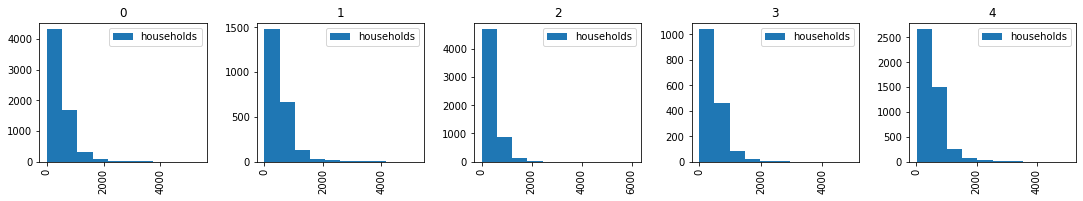

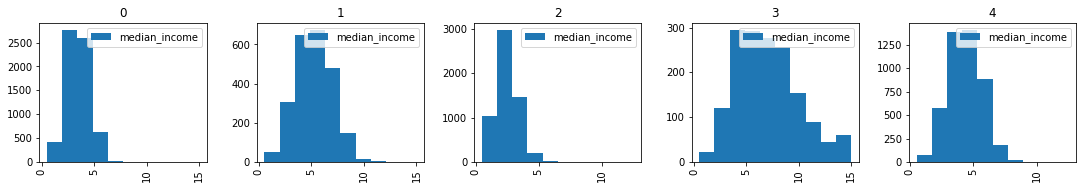

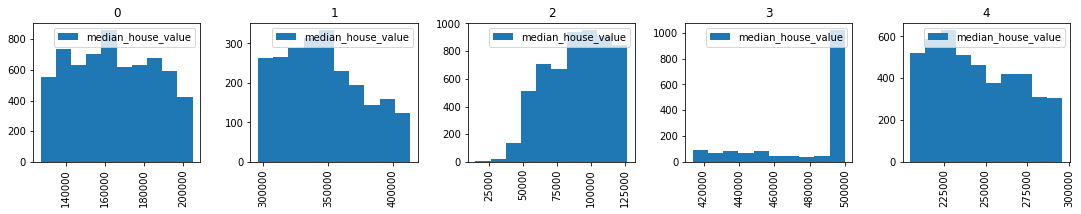

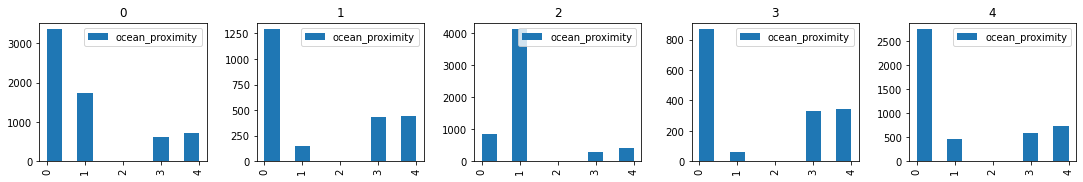

In [ ]:
X['cluster'] = kmeanModel.labels_

cols = list(X.columns)
cols.remove('cluster')

for col in cols:
  X[col].hist(by=X['cluster'], layout=[5,5], figsize=(18,18), legend=True)

Also from the hisograms it is clear that the Kmeans is clustering just basing on median_house_value, so it's biased by features with high values.

**Visualizing** with 3D PCA

In [ ]:
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)
pca.explained_variance_ratio_


array([9.99529879e-01, 4.48092984e-04, 1.95889242e-05])

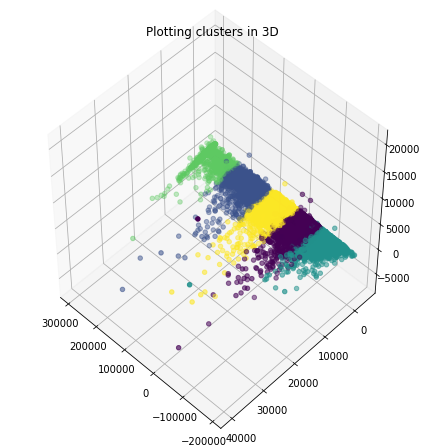

In [ ]:
X_pca = pd.DataFrame(X_pca)
scatter_plot_3d(X_pca, kmeanModel)

## Experiment 2: DIMENSIONALITY REDUCTION ON RAW DATA


We just reduce the dimensionality of the data using PCA, to check if this may help for clustering.

In [ ]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
pca.explained_variance_ratio_

array([9.99529878e-01, 4.48092984e-04])

Time needed to compute  2  clusters:  0.1908407211303711
Time needed to compute  3  clusters:  0.3077120780944824
Time needed to compute  4  clusters:  0.3333122730255127
Time needed to compute  5  clusters:  0.35550832748413086
Time needed to compute  6  clusters:  0.6154577732086182
Time needed to compute  7  clusters:  0.606661319732666
Time needed to compute  8  clusters:  0.6381769180297852
Time needed to compute  9  clusters:  0.7373020648956299
Time needed to compute  10  clusters:  0.6914610862731934
Time needed to compute  11  clusters:  0.758357048034668
Time needed to compute  12  clusters:  0.7793567180633545
Time needed to compute  13  clusters:  0.8002142906188965
Time needed to compute  14  clusters:  0.9027879238128662
2 : 54106.905978392766
3 : 37027.29083324489
4 : 27598.271516329823
5 : 20797.264103910846
6 : 17593.962227784396
7 : 14979.57689599969
8 : 13200.737152109932
9 : 11441.79190658175
10 : 10223.90678722763
11 : 9367.998913631242
12 : 8675.60770727328
13 : 7

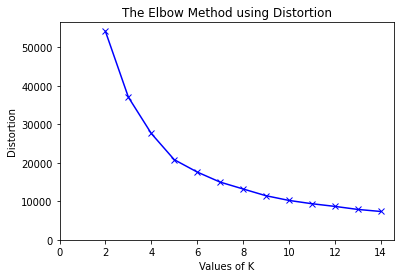

2 : 85909868637395.17
3 : 39088130438097.586
4 : 21304323610353.223
5 : 12382621902666.662
6 : 8831274182789.15
7 : 6533352691307.757
8 : 4953884852194.476
9 : 3808351175818.5977
10 : 3160143931356.9106
11 : 2580591069244.2173
12 : 2175886818900.276
13 : 1861931130669.469
14 : 1586029266661.912


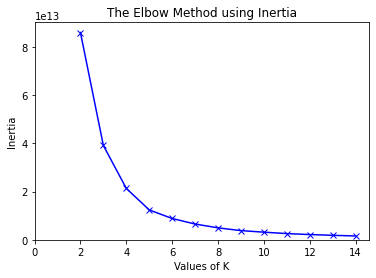

2 : 0.6285891125445264
3 : 0.5681979938796468
4 : 0.5604663041056942
5 : 0.5777590874248328
6 : 0.555246961160136
7 : 0.5475010499892715
8 : 0.5519185859032504
9 : 0.5466973944198634
10 : 0.5420680715956815
11 : 0.5413551852018048
12 : 0.538040208282657
13 : 0.5381221316743157
14 : 0.5398816054509834


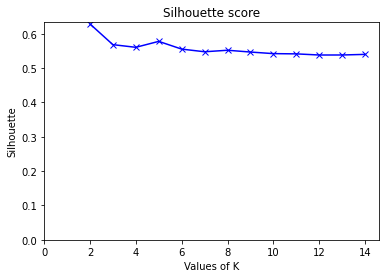

In [ ]:
models = elbow(X_pca,15)

In [ ]:
k = 5
kmeanModel = models[k-2]
kmeans_model_info(kmeanModel,X_pca)

Number of clusters:  5

Centers:
  [[-1.16631716e+05 -2.11222548e+02]
 [ 3.88757616e+04  2.19713372e+02]
 [ 2.73796226e+05 -4.34980659e+02]
 [-4.19048181e+04  1.20224218e+02]
 [ 1.40375856e+05  6.31341563e+01]] 

|Cluster  0 |:  5736
|Cluster  1 |:  4525
|Cluster  2 |:  1610
|Cluster  3 |:  6443
|Cluster  4 |:  2311

Silhouette score average:  0.5777590874248328
Inertia:  12382621902666.662
Distortion:  20797.264103910846


Still very bad metrics! PCA alone is not enough. The plot, in fact, is very similar to the one obtained clustering raw data. This means that features have to be changed.

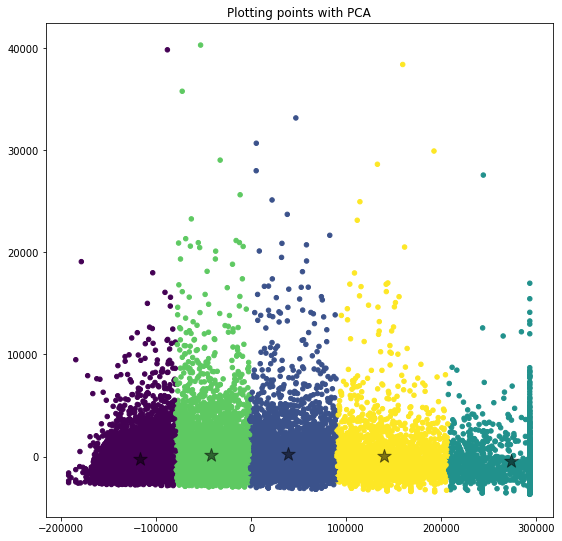

In [ ]:
scatter_plot(X_pca,kmeanModel,0,1)

## EDA

### Some statistics

In [ ]:
df = raw_df
print(df.head(5))
df.info()

   longitude  latitude  ...  median_house_value  ocean_proximity
0    -122.23     37.88  ...            452600.0         NEAR BAY
1    -122.22     37.86  ...            358500.0         NEAR BAY
2    -122.24     37.85  ...            352100.0         NEAR BAY
3    -122.25     37.85  ...            341300.0         NEAR BAY
4    -122.25     37.85  ...            342200.0         NEAR BAY

[5 rows x 10 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-nu

In [ ]:
df.describe()

longitude      latitude  ...  median_income  median_house_value
count  20640.000000  20640.000000  ...   20640.000000        20640.000000
mean    -119.569704     35.631861  ...       3.870671       206855.816909
std        2.003532      2.135952  ...       1.899822       115395.615874
min     -124.350000     32.540000  ...       0.499900        14999.000000
25%     -121.800000     33.930000  ...       2.563400       119600.000000
50%     -118.490000     34.260000  ...       3.534800       179700.000000
75%     -118.010000     37.710000  ...       4.743250       264725.000000
max     -114.310000     41.950000  ...      15.000100       500001.000000

[8 rows x 9 columns]

In [ ]:
df.describe(include=['object', 'bool'])

ocean_proximity
count            20640
unique               5
top          <1H OCEAN
freq              9136

In [ ]:
#Get the percentage of rows for each category
df['ocean_proximity'].value_counts(normalize=True)

<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: ocean_proximity, dtype: float64

In [ ]:
#The map method can be used to replace values in a column by passing a dictionary 
#of the form {old_value: new_value} as its argument:
#d = {'No' : False, 'Yes' : True}
#df['International plan'] = df['International plan'].map(d)
#or
#df = df.replace({'Voice mail plan': d})



#This is how we group:
#df.groupby(by=grouping_columns)[columns_to_show].function()
#1. First, the groupby method divides the grouping_columns by their values. 
#   They become a new index in the resulting dataframe.
#2. Then, columns of interest are selected (columns_to_show). 
#   If columns_to_show is not included, all non groupby clauses will be included.
#3. Finally, one or several functions are applied to the obtained groups per selected columns.

In [ ]:
pd.crosstab(df['median_house_value'], df['ocean_proximity'])
#pd.crosstab(df['median_house_value'], df['ocean_proximity'], normalize=True)

ocean_proximity     <1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
median_house_value                                                 
14999.0                     0       4       0         0           0
17500.0                     1       0       0         0           0
22500.0                     0       2       0         1           1
25000.0                     0       1       0         0           0
26600.0                     0       1       0         0           0
...                       ...     ...     ...       ...         ...
498800.0                    1       0       0         0           0
499000.0                    0       0       0         1           0
499100.0                    1       0       0         0           0
500000.0                    9       1       0         8           9
500001.0                  532      27       0       194         212

[3842 rows x 5 columns]

In [ ]:
df.pivot_table(['median_house_value', 'population', 'median_income'],
               ['ocean_proximity'], aggfunc='mean')

median_house_value  median_income   population
ocean_proximity                                                
<1H OCEAN             240084.285464       4.230682  1520.290499
INLAND                124805.392001       3.208996  1391.046252
ISLAND                380440.000000       2.744420   668.000000
NEAR BAY              259212.311790       4.172885  1230.317467
NEAR OCEAN            249433.977427       4.005785  1354.008653

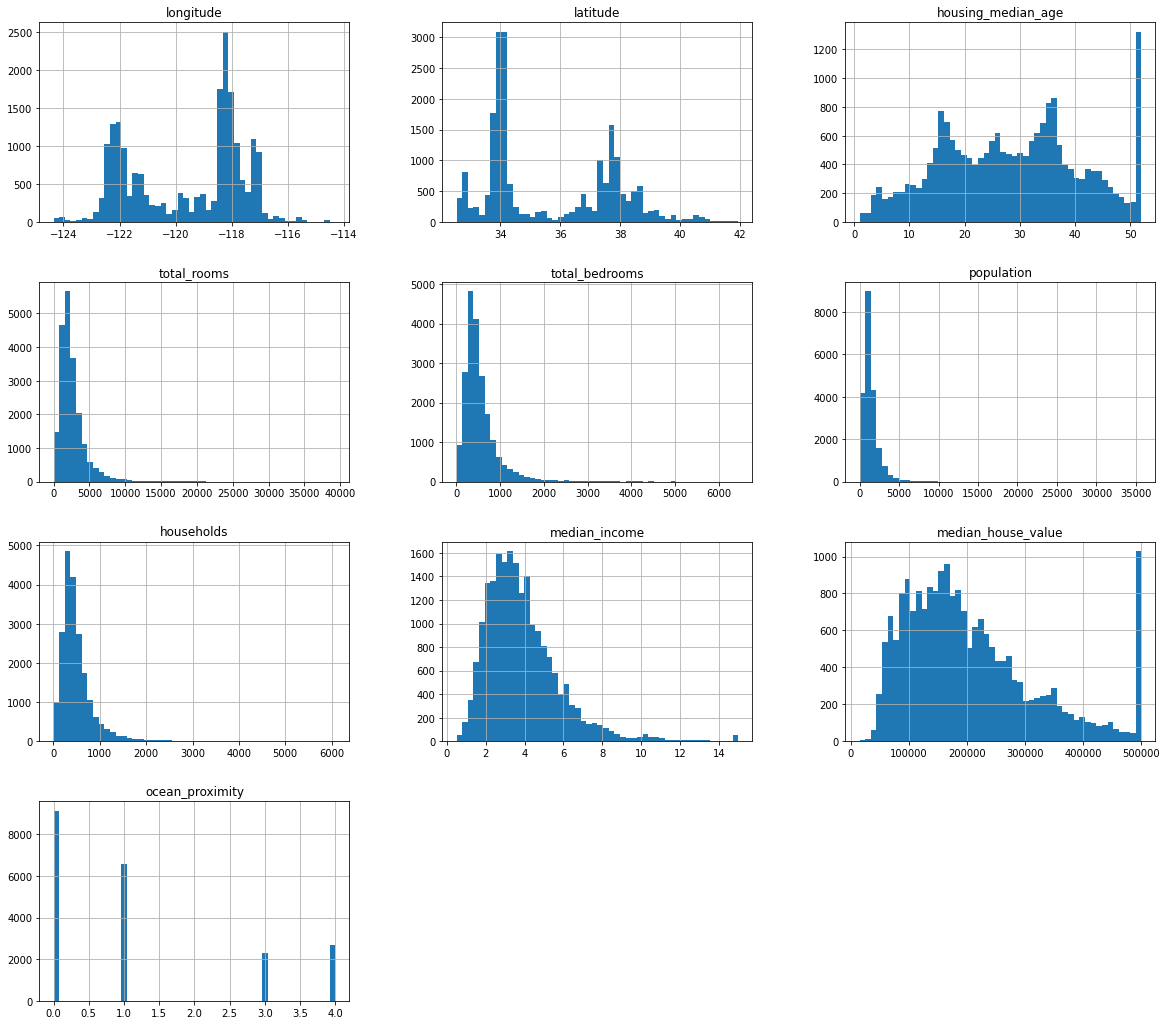

In [ ]:
ax = df.hist(figsize=[20, 18], bins = 50)

### Correlation



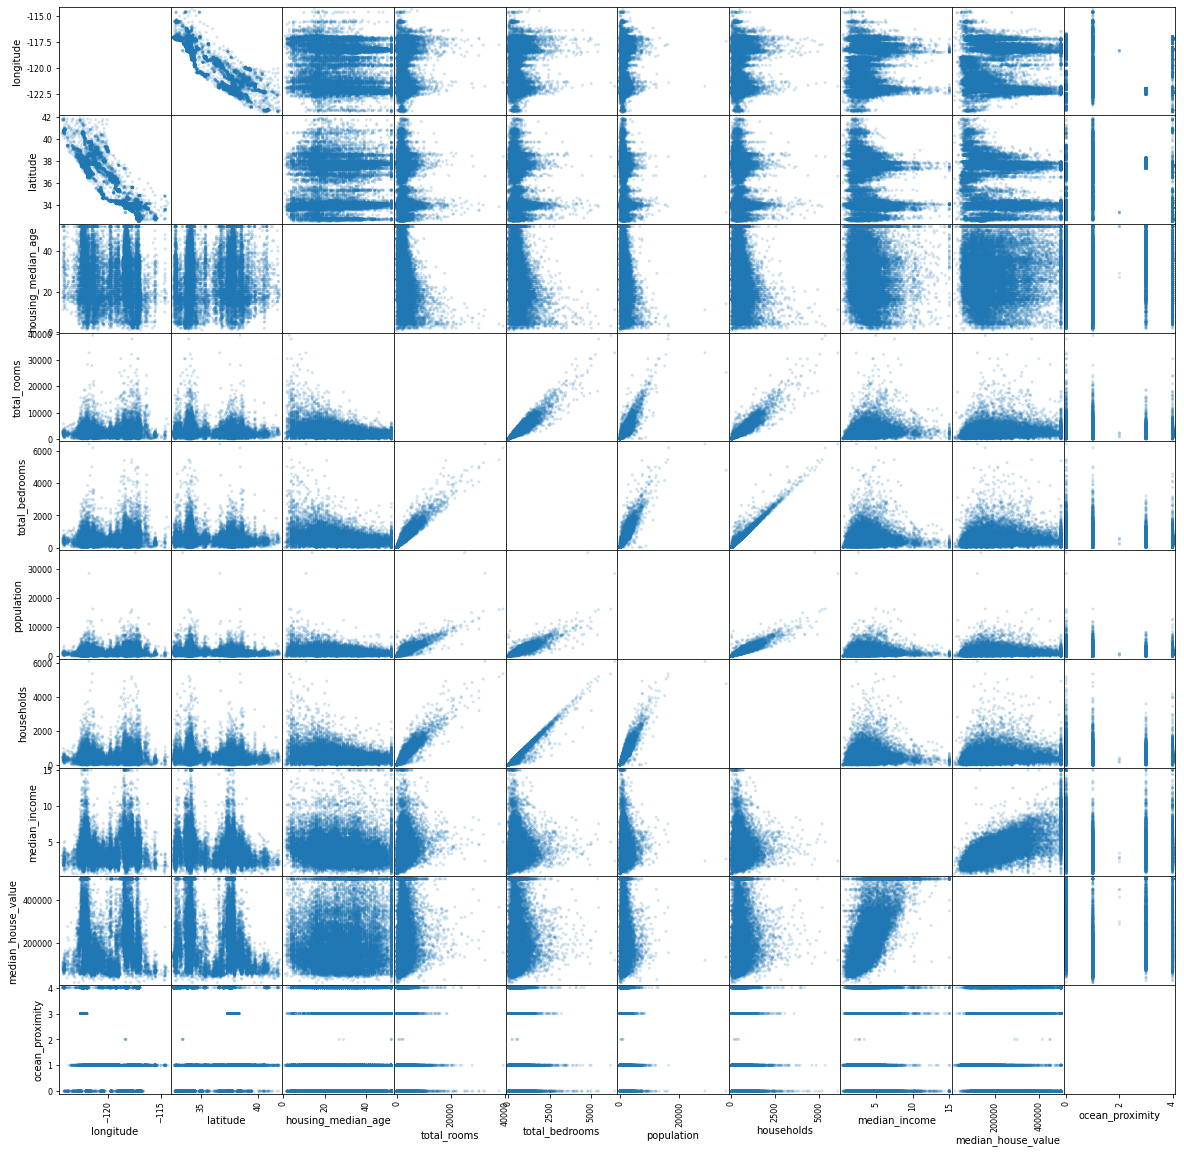

In [ ]:
ax = pd.plotting.scatter_matrix(df, alpha=0.2, figsize = [20, 20], diagonal='none')

We can notice a positive correlation between:

*   total_rooms and total_bedrooms (of course rooms and bedrooms are correlated since bedrooms are actually rooms)
*   total_rooms and population (of course, if there are more rooms there is space for more people)
*   total_rooms and households
*   total_bedrooms and households
*   total_bedrooms and population
*   population and households
*   median_house_value and median_income

We can notice a negative correlation between:

*   latitude and longitude





**Checking different category values**



In [ ]:
print(df.ocean_proximity.unique())
df.groupby('ocean_proximity')['ocean_proximity'].count()

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


ocean_proximity
<1H OCEAN     9126
INLAND        6547
ISLAND           5
NEAR BAY      2289
NEAR OCEAN    2658
Name: ocean_proximity, dtype: int64

In [ ]:
#df.loc[df['ocean_proximity'] == 'NEAR BAY', 'ocean_proximity'] = 'NEAR OCEAN'
#df.ocean_proximity.unique()

array(['NEAR OCEAN', '<1H OCEAN', 'INLAND', 'ISLAND'], dtype=object)

### Filling Missing data ('IMPUTATION')

In [ ]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

207 rows have a null value for the 'total_bedrooms' column. We can try to replace null value with the median of total_rooms, having the same number of total_rooms (because of course the number of bedrooms depends on the number of rooms).

In [ ]:
median_bedrooms = df.groupby('total_rooms')['total_bedrooms'].median().round(0)
#computes medians and rounds to the nearest integer
print(median_bedrooms.head(20))
print(median_bedrooms[8.0])

total_rooms
2.0      2.0
6.0      2.0
8.0      1.0
11.0    11.0
12.0     4.0
15.0     4.0
16.0     4.0
18.0     4.0
19.0    12.0
20.0     4.0
21.0     7.0
22.0     9.0
24.0     6.0
25.0     5.0
26.0     8.0
28.0     4.0
30.0     4.0
32.0     8.0
36.0     8.0
37.0    11.0
Name: total_bedrooms, dtype: float64
1.0


In [ ]:

def fill_median(row):
  if (math.isnan(row['total_bedrooms'])):
    #Series such that the key is the number of total_rooms, the value is the median of total_bedrooms
    rooms = row['total_rooms']
    median_value = median_bedrooms[rooms]
    return median_value
  else:
    return row['total_bedrooms']

df['total_bedrooms'] = df.apply(lambda x: fill_median(x), axis=1)
df.isnull().sum() #there are still 15 bedrooms with a null value (maybe there is no data
#having the same number of rooms)
df = df.dropna() #we remove them since they are few
df.isnull().sum() 

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

## Experiment 3: FEATURE EXPANSION AND PROJECTION

Having a lot of correlated features may be overly redundant and you may be using more data than you need to reach the same patterns. 
Therefore, we want to reduce the dimensionality and redundancy of the data considering combinations of correlated features, instead of individual features. 

We propose different computations of features, creating new ones, and after that we remove some noise, projecting the obtained features into a lower dimensional space (4 dimensions).


### Feature expansion

In [ ]:
X_feat = df.copy()

1st attempt to encode latitude and longitude: Cartesian coordinates starting from the spherical ones

In [ ]:
X_feat['cos_lat'] = X_feat['latitude'].apply(lambda x: math.cos(x))
X_feat['cos_lon'] = X_feat['longitude'].apply(lambda x: math.cos(x))
X_feat['sin_lat'] = X_feat['latitude'].apply(lambda x: math.sin(x))
X_feat['sin_lon'] = X_feat['longitude'].apply(lambda x: math.sin(x))
X_feat['X'] = X_feat['cos_lat'] * X_feat['cos_lon']
X_feat['Y'] = X_feat['cos_lat'] * X_feat['sin_lon']
X_feat['Z'] = X_feat['sin_lat']
X_feat.drop(['cos_lat', 'cos_lon','sin_lat','sin_lon','longitude','latitude'], axis=1, inplace=True)

In [ ]:
X_feat['xyz'] = X_feat['X'] * X_feat['Y'] * X_feat['Z']
X_feat.drop(['X', 'Y','Z'], axis=1, inplace=True)

2nd attempt to encode latitude and longitude (used in the best model)

In [ ]:
X_feat['angle'] = X_feat['longitude'] / X_feat['latitude']
X_feat['angle'] = X_feat['angle'].apply(lambda x: math.tanh(x))

X_feat['latitude'] = X_feat['latitude'].apply(lambda x: x * x)
X_feat['longitude'] = X_feat['longitude'].apply(lambda x: x * x)
X_feat['radius'] = X_feat['latitude'] + X_feat['longitude']
X_feat['radius'] = X_feat['radius'].apply(lambda x: math.sqrt(x))

X_feat.drop(['longitude','latitude'], axis=1, inplace=True)

Transforming the other features (used with both 1st and 2nd featurization of lat and lon)

In [ ]:
#CONSIDERING THE RATIO HOUSEHOLDS/POPULATION
# where HOUSEHOLDS are people residing in a unit house of a block, POPULATION are people residing in each block
X_feat['population_*_income'] = X_feat['population'] * X_feat['median_income']
X_feat['households_population_ratio'] = X_feat['households'] / X_feat['population']
#new
X_feat['bedrooms/households'] = X_feat['total_bedrooms'] / X_feat['households']

X_feat.drop(['households', 'population'], axis=1, inplace=True)

#Maybe, using the ratio total_bedrooms/total_rooms is more useful than using just total_bedrooms
X_feat['bedrooms_rooms_ratio'] = X_feat['total_bedrooms'] / X_feat['total_rooms']
#instead of rooms we consider total_rooms-total_bedrooms (so just rooms that are not bedrooms)
X_feat['total_other_rooms'] = X_feat['total_rooms'] - X_feat['total_bedrooms']
X_feat.drop(['total_bedrooms','total_rooms'], axis=1, inplace=True)
#we decide to keep total_rooms also

#CONSIDERING TOGETHER MEDIAN INCOME OF PEOPLE LIVING THERE AND MEDIAN HOUSE VALUE
X_feat['cumulative_wealth'] = X_feat['median_income'] + X_feat['median_house_value']
#X_feat['cumulative_wealth'] = X_feat['median_income'] / X_feat['median_house_value']
X_feat.drop(['median_income','median_house_value'], axis=1, inplace=True)


#LABEL ENCODING
#le = preprocessing.LabelEncoder()
#X_feat['ocean_proximity'] = le.fit_transform(X_feat['ocean_proximity'])

#We noticed that one-hot-encoding performs significantly better than label encoding
#ONE HOT ENCODING
X_feat = pd.get_dummies(X_feat) 


#NORMALIZE SOMETHING ELSE
# Scaling is a key-point in algorithms where the distance between the data points is important
# (Kmeans is based on distances do it's almost required to do scaling or normalization)

# Normalize in [-1,1]
X_feat = X_feat / X_feat.max()

#Normalizing in [0,1]
#X_feat =  (X_feat - X_feat.min()) / (X_feat.max() - X_feat.min())




X_feat.head(5)


housing_median_age  ...  ocean_proximity_NEAR OCEAN
0            0.788462  ...                         0.0
1            0.403846  ...                         0.0
2            1.000000  ...                         0.0
3            1.000000  ...                         0.0
4            1.000000  ...                         0.0

[5 rows x 15 columns]

**Outlier detection and removal**

In [ ]:
#Removing outliers with an anomaly detection algorithm
print(X_feat.shape)
iforest = IsolationForest(n_estimators=100, contamination=.03)
pred = iforest.fit_predict(X_feat)
outlier_index = where(pred==-1)
outliers = X_feat.iloc[outlier_index]
no_outlier = where(pred!=-1)
X_feat = X_feat.iloc[no_outlier]
print(outliers.shape) #there are 104 outliers
print(X_feat.shape)

(20625, 15)
(619, 15)
(20006, 15)


### Feature projection (PCA)

PCA takes the eigenvectors such that the variance is maximized.

In [ ]:
pca = decomposition.PCA(n_components=3)
pca.fit(X_feat)
X_pca = pca.transform(X_feat)
pca.explained_variance_ratio_

array([0.49513098, 0.2345227 , 0.14890006])

### Running Elbow method with Kmeans (1st featurization)

The first featurization takes into account the new features X,Y,Z defined using longitude and latitude, and does not consider PCA.

Time needed to compute  2  clusters:  0.31951904296875
Time needed to compute  3  clusters:  0.24458980560302734
Time needed to compute  4  clusters:  0.39639782905578613
Time needed to compute  5  clusters:  0.4294164180755615
Time needed to compute  6  clusters:  0.581672191619873
Time needed to compute  7  clusters:  0.6002240180969238
Time needed to compute  8  clusters:  0.8974637985229492
Time needed to compute  9  clusters:  1.0915765762329102
Time needed to compute  10  clusters:  1.0099942684173584
Time needed to compute  11  clusters:  1.1293272972106934
Time needed to compute  12  clusters:  1.3204717636108398
Time needed to compute  13  clusters:  1.4562358856201172
Time needed to compute  14  clusters:  1.3932409286499023
2 : 0.9415462986083091
3 : 0.7784821285652768
4 : 0.6867120303389187
5 : 0.6183950418965565
6 : 0.5688683198808163
7 : 0.5355298765251671
8 : 0.5077268798054666
9 : 0.4812531153205173
10 : 0.46151681154894353
11 : 0.4430604756785567
12 : 0.431564664781741

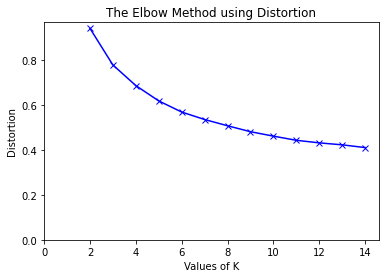

2 : 19679.100413260974
3 : 14114.868803980475
4 : 11296.13560368499
5 : 9152.747794839512
6 : 7774.0198771420555
7 : 6897.594509110659
8 : 6132.730882702483
9 : 5512.636860275815
10 : 5108.639968109938
11 : 4798.790254930188
12 : 4509.568352193299
13 : 4264.678347052963
14 : 4011.02637975462


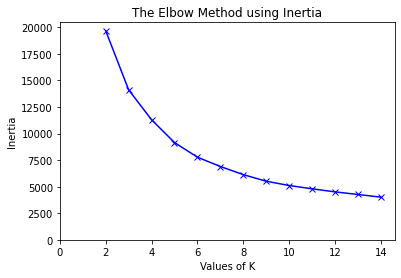

2 : 0.33120518141475214
3 : 0.41733938707491114
4 : 0.46592116243036624
5 : 0.4785781602964876
6 : 0.46182141881614286
7 : 0.47266755414533657
8 : 0.45500781943052804
9 : 0.43501692586072727
10 : 0.4286827662166876
11 : 0.36680837475389794
12 : 0.36516161099227323
13 : 0.4047949581811908
14 : 0.40608115860241123


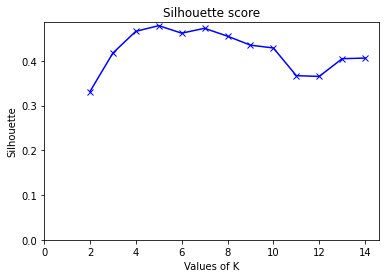

In [ ]:
models = elbow(X_feat,15)

In [ ]:
k = 5 #choose k analyzing the results of the elbow method
kmeanModel = models[k-2]
kmeans_model_info(kmeanModel, X_feat)

Number of clusters:  5

Centers:
  [[ 5.68123029e-01 -3.62883901e-01 -6.03820869e-01  4.41687240e-01
   4.90454145e-02  2.43436984e-01  3.07569132e-02  2.17920950e-01
   5.94316059e-02  4.79281785e-01  1.00000000e+00 -6.66133815e-15
   4.77048956e-18  1.68337566e-14  1.53072000e-14]
 [ 4.69981635e-01  6.96659394e-03 -5.54257839e-01  5.34903189e-01
   3.74806717e-02  2.50323854e-01  3.36967104e-02  2.01402514e-01
   6.40925449e-02  2.72382537e-01  1.53210777e-14  1.00000000e+00
   1.93530088e-17  1.05193632e-14  1.05471187e-14]
 [ 7.32602411e-01 -9.36724727e-01 -2.52885648e-01  1.01183882e-01
   3.91473942e-02  2.78592002e-01  3.08546340e-02  2.10747337e-01
   5.63413735e-02  5.10936050e-01  2.02060590e-14 -5.16253706e-15
  -2.81892565e-18  1.00000000e+00 -1.27675648e-15]
 [ 4.72881161e-01  1.54196918e-01 -2.15256408e-01 -7.46599752e-01
   3.00010555e-02  2.34389620e-01  3.20447478e-02  2.05915074e-01
   5.50825320e-02  1.78064603e-01  3.29341317e-02  9.64670659e-01
  -4.44522891e-18 -2

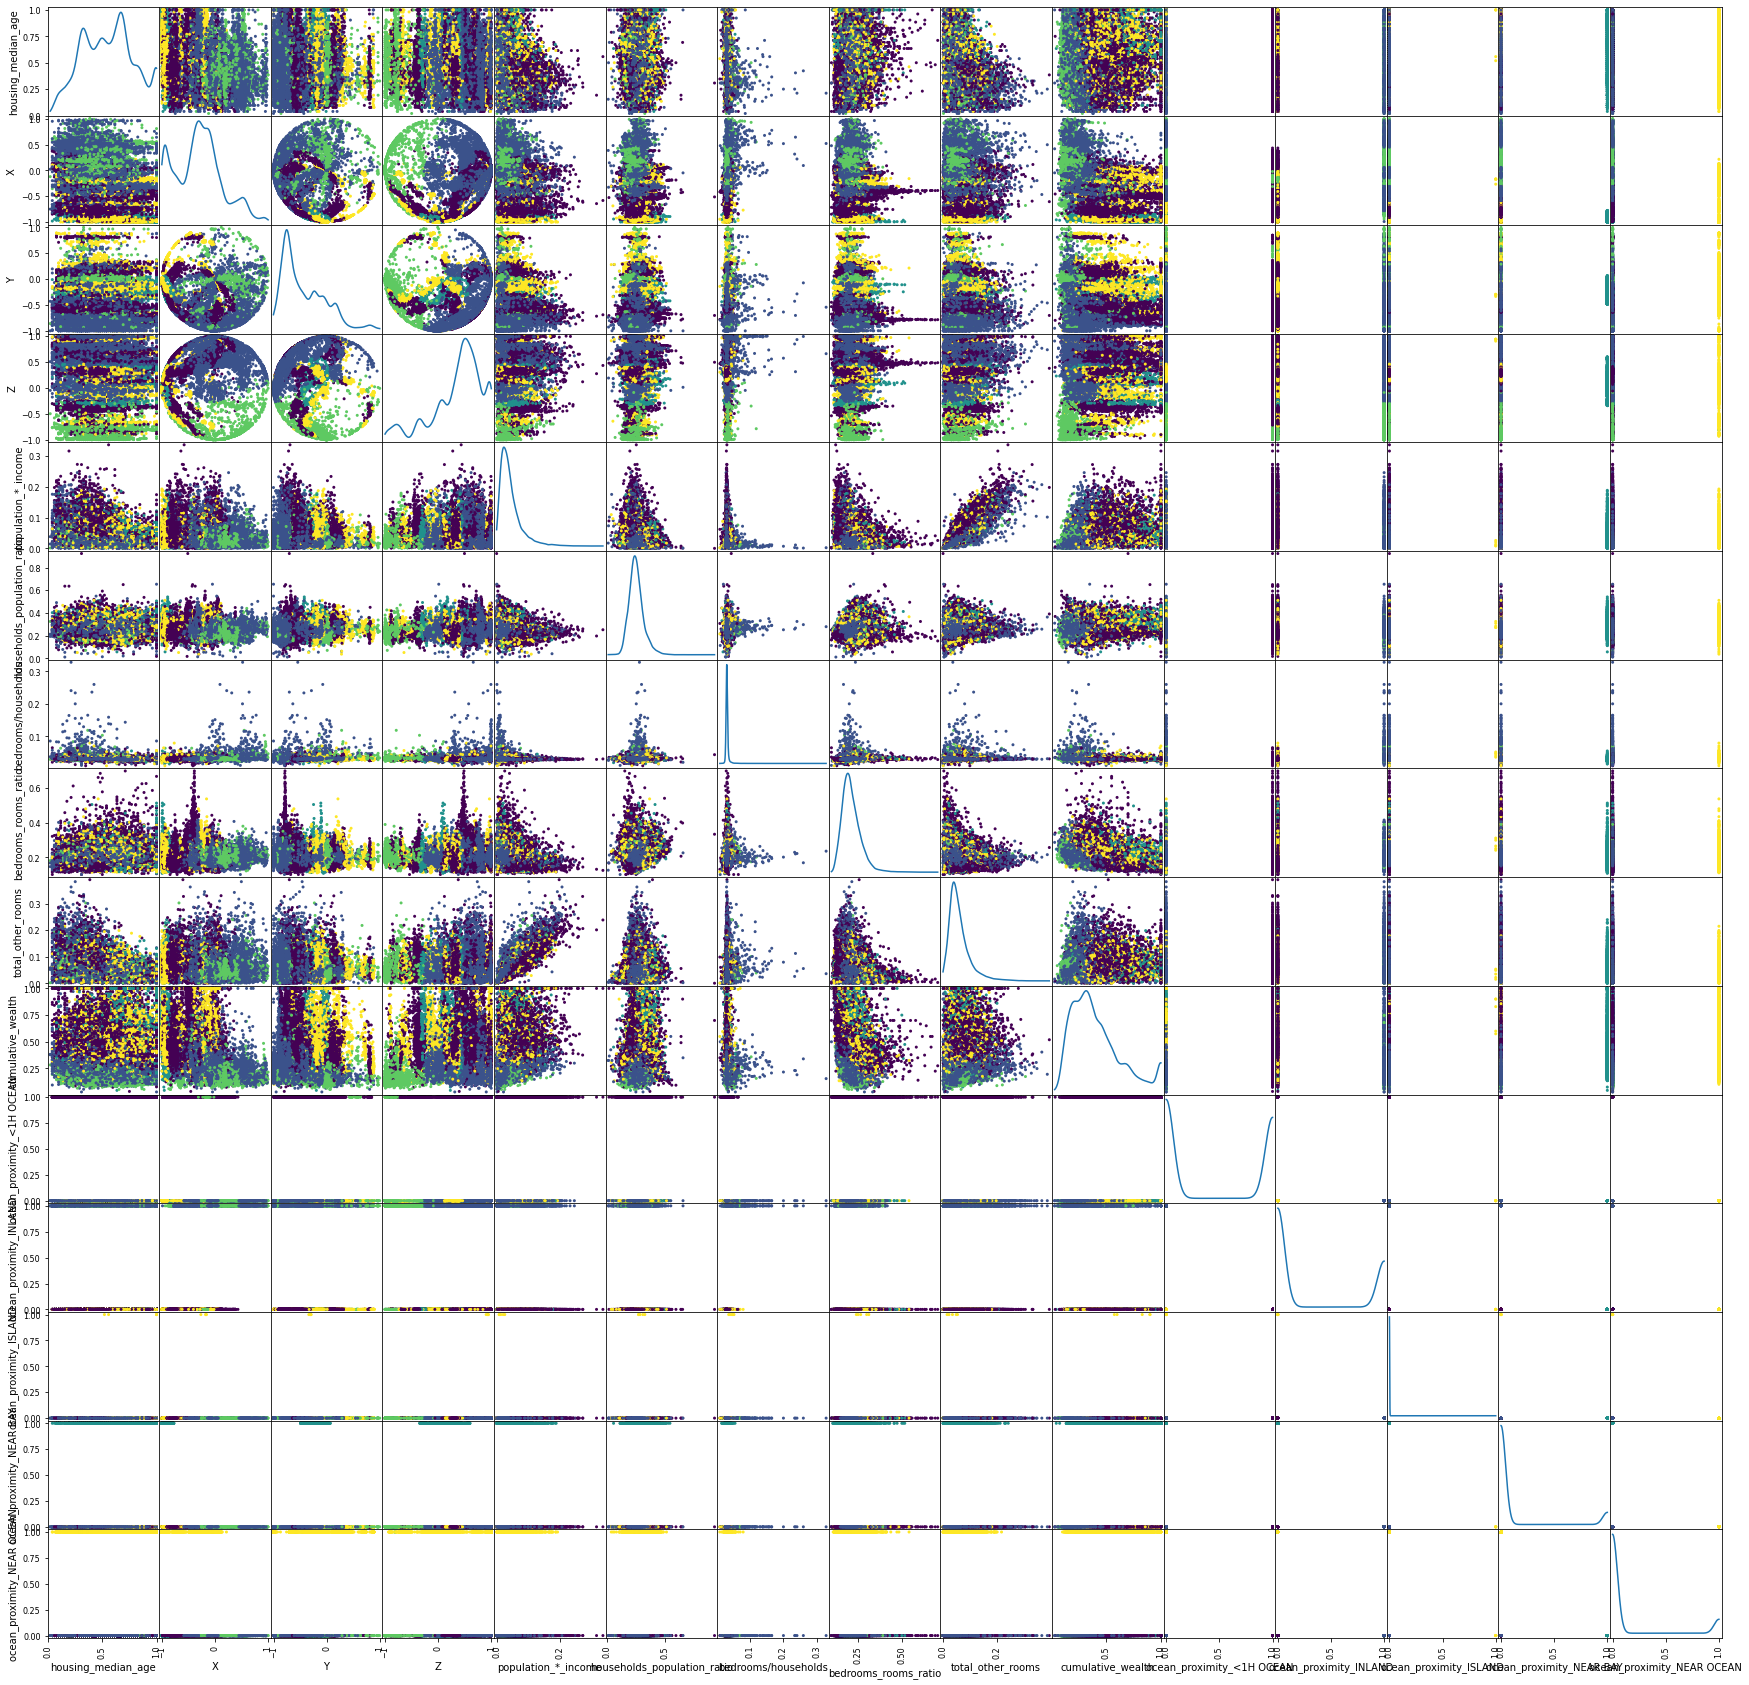

In [ ]:
ax = pd.plotting.scatter_matrix(X_feat, alpha=1, figsize = [30, 30], c=kmeanModel.labels_, diagonal='kde')

### Running Elbow method with Kmeans (best featurization)

Time needed to compute  2  clusters:  0.11601614952087402
Time needed to compute  3  clusters:  0.11665773391723633
Time needed to compute  4  clusters:  0.12160491943359375
Time needed to compute  5  clusters:  0.1738114356994629
Time needed to compute  6  clusters:  0.24333977699279785
Time needed to compute  7  clusters:  0.289827823638916
Time needed to compute  8  clusters:  0.37210607528686523
Time needed to compute  9  clusters:  0.4102294445037842
Time needed to compute  10  clusters:  0.4932267665863037
Time needed to compute  11  clusters:  0.5071849822998047
Time needed to compute  12  clusters:  0.5859279632568359
Time needed to compute  13  clusters:  0.669654130935669
Time needed to compute  14  clusters:  0.726661205291748
2 : 0.43474982938700296
3 : 0.21265417702132824
4 : 0.06763952501002493
5 : 0.06000793469775493
6 : 0.05316666054430787
7 : 0.048017728338799644
8 : 0.04513099036421196
9 : 0.041947099499136574
10 : 0.03996780134075673
11 : 0.03790415118658463
12 : 0.0

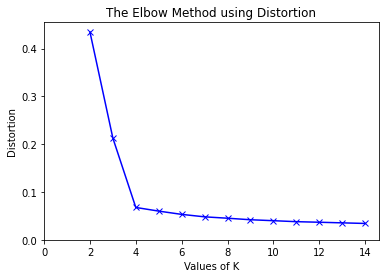

2 : 6694.662615053713
3 : 2430.249510621244
4 : 128.21364934714873
5 : 100.44890635123764
6 : 82.56268538235447
7 : 71.01369001991429
8 : 60.077775125216434
9 : 49.184548728788684
10 : 44.75950282809426
11 : 41.0913880343898
12 : 37.83194382738649
13 : 34.964476841798096
14 : 32.421470613680185


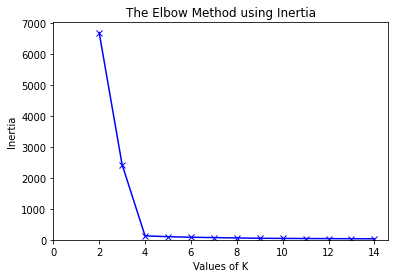

2 : 0.6367613513718202
3 : 0.8267809546755721
4 : 0.9323020481971063
5 : 0.6972143164950522
6 : 0.5573734237426107
7 : 0.5639232420186858
8 : 0.5158697035837978
9 : 0.4625895345314359
10 : 0.44916494448234634
11 : 0.4192687039071014
12 : 0.40850425860613515
13 : 0.41641983316595865
14 : 0.41208423217294476


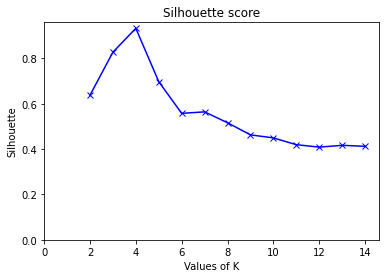

In [ ]:
models = elbow(X_pca,15)

In [ ]:
k = 4 #choose k analyzing the results of the elbow method
kmeanModel = models[k-2]
kmeans_model_info(kmeanModel, X_pca)

Number of clusters:  4

Centers:
  [[-0.6323255  -0.18899016 -0.00547395]
 [ 0.79998436 -0.29117045  0.00246517]
 [ 0.13567108  0.79611368 -0.66768073]
 [ 0.11461683  0.75473685  0.74888917]] 

|Cluster  0 |:  9011
|Cluster  1 |:  6401
|Cluster  2 |:  2405
|Cluster  3 |:  2189

Silhouette score average:  0.9323020481971063
Inertia:  128.21364934714873
Distortion:  0.06763952501002493


Silhouette score has improved. Distortion and inertia are significantly lower than before.

**Scatter matrix on PCA data**

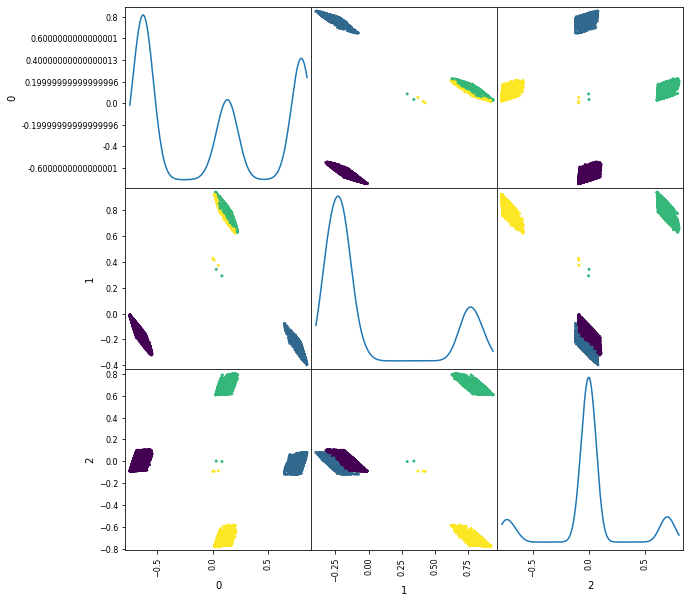

In [ ]:
ax = pd.plotting.scatter_matrix(X_pca, alpha=1, figsize = [10, 10], c=kmeanModel.labels_, diagonal='kde')

Clusters are better separated also in the plots after using PCA, because we remove the noise from data. There are some outliers for some clusters in every dimension.

**Scatter matrix on original data**

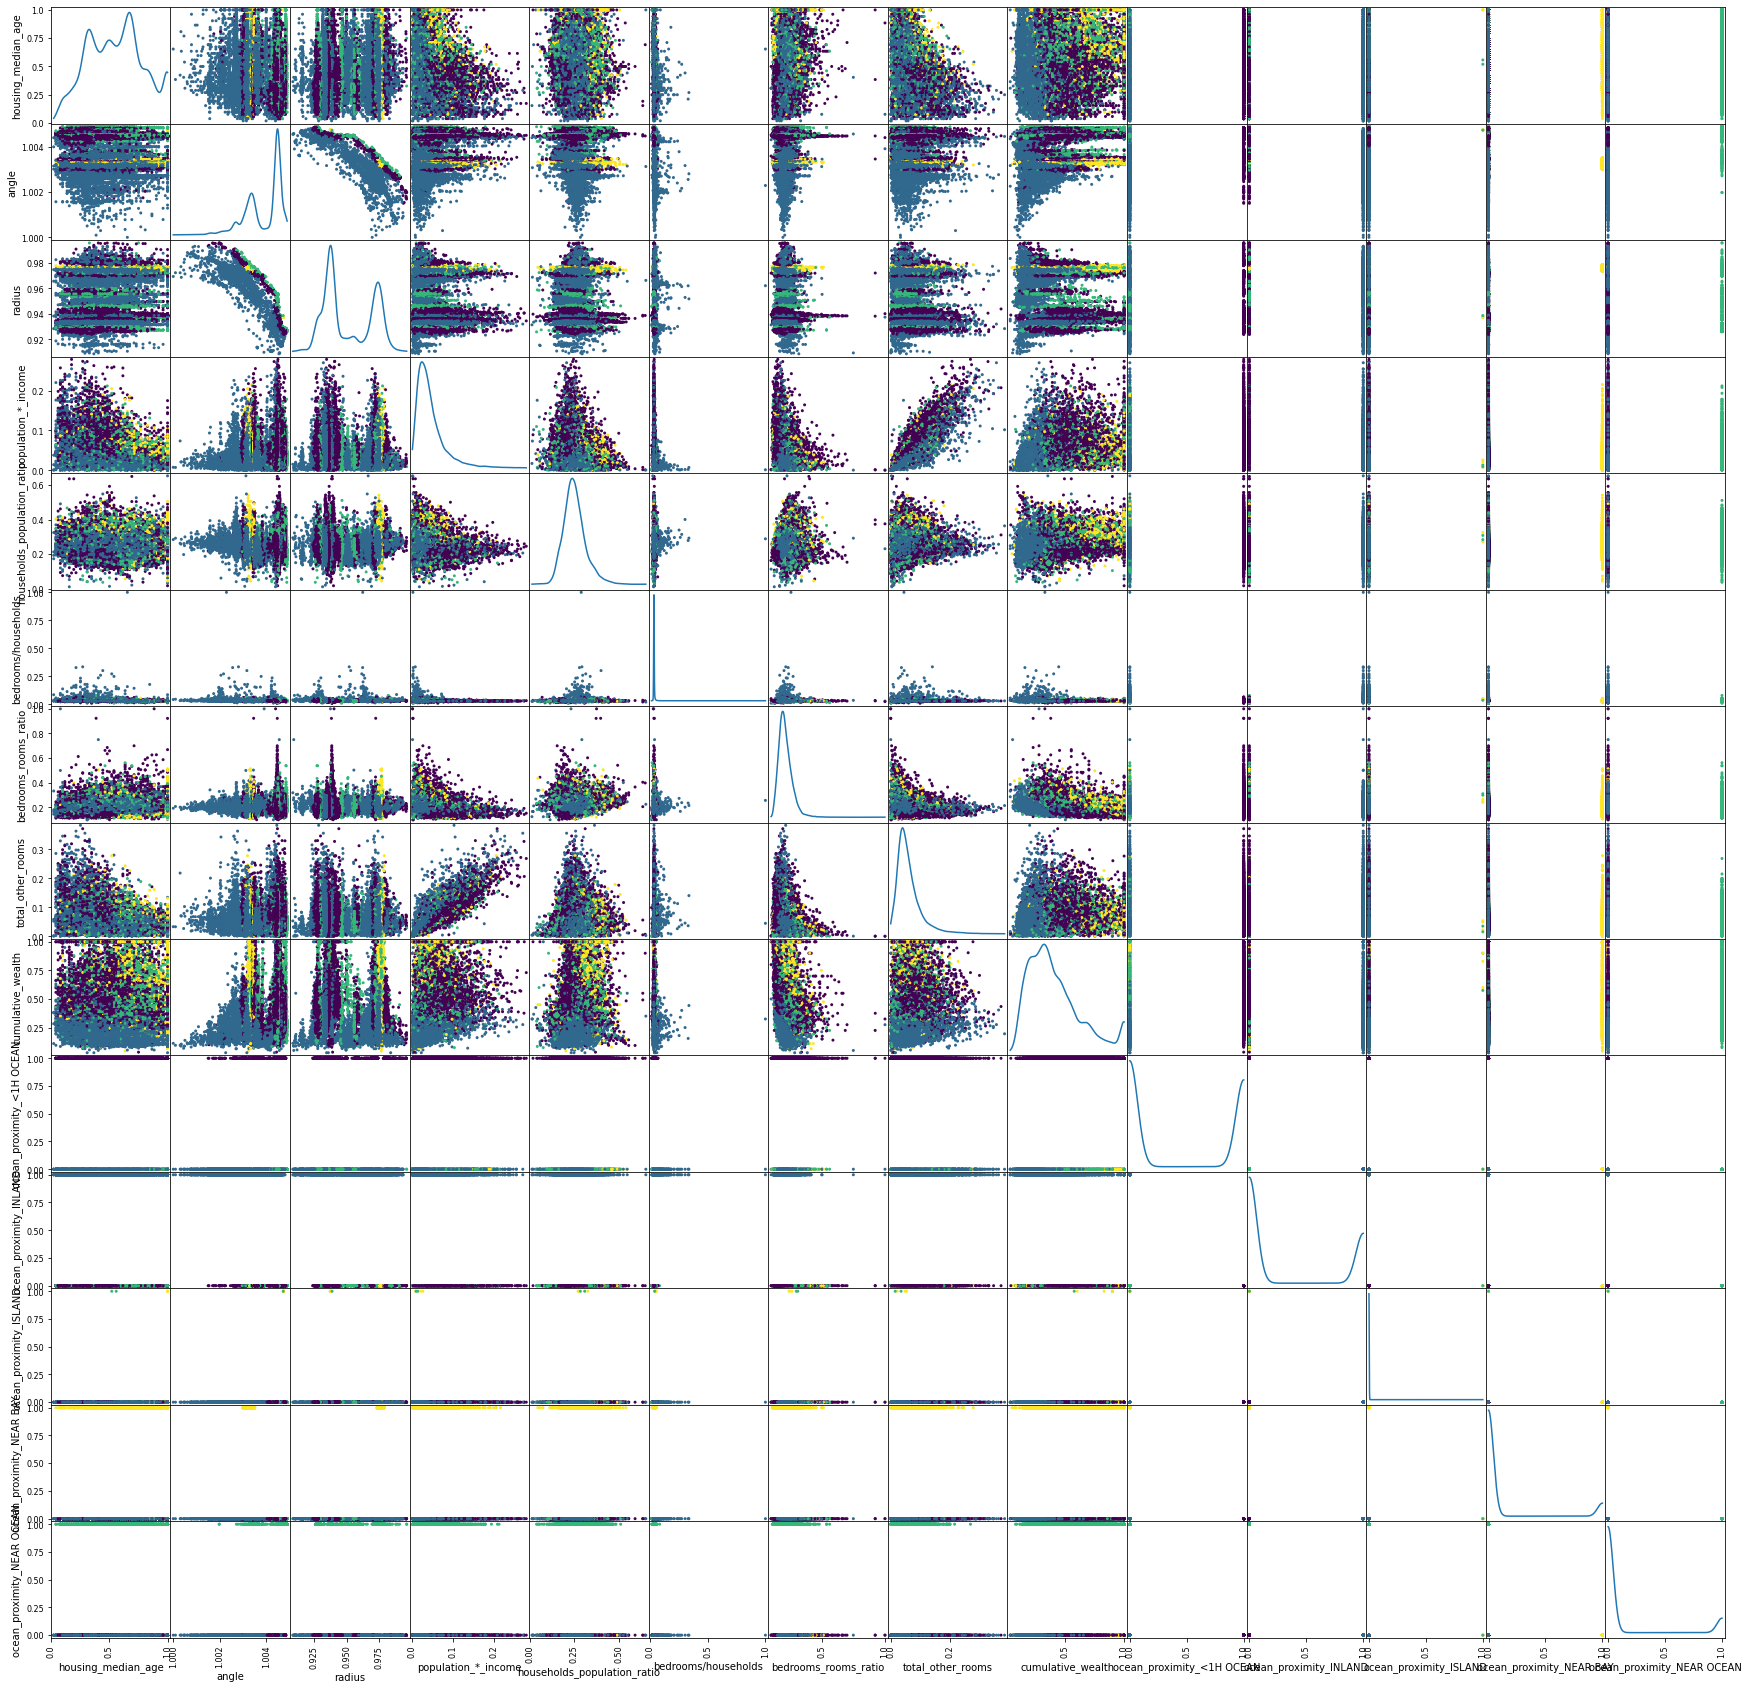

In [ ]:
ax = pd.plotting.scatter_matrix(X_feat, alpha=1, figsize = [30, 30], c=kmeanModel.labels_, diagonal='kde')

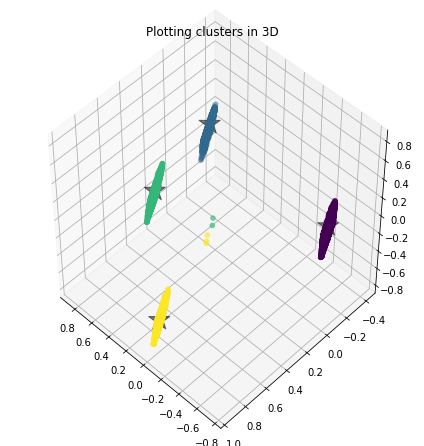

In [ ]:
scatter_plot_3d(X_pca, kmeanModel)

(Centroids are "behind" cluster points in the 3dimensional space)

### Trying to interpret the clusters


**Plotting histograms**

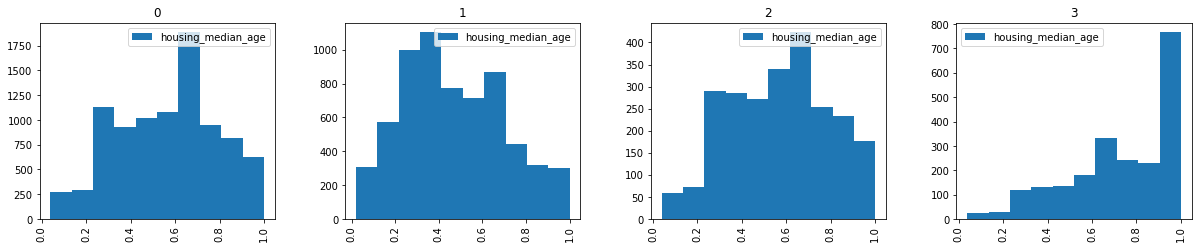

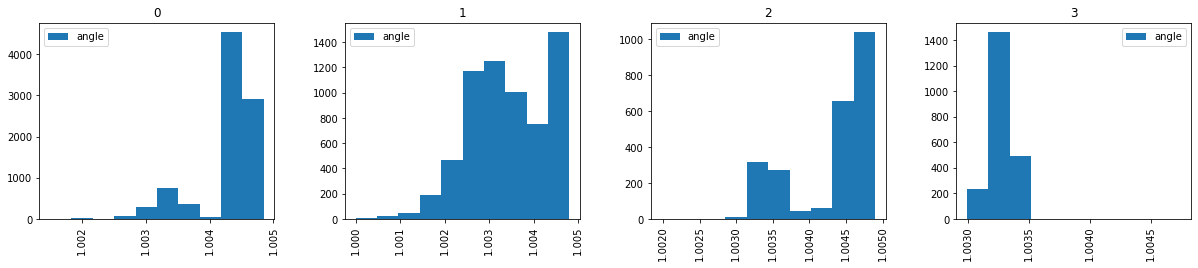

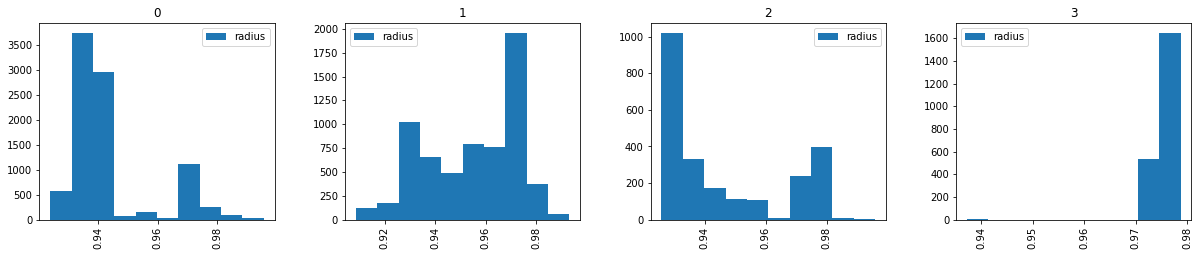

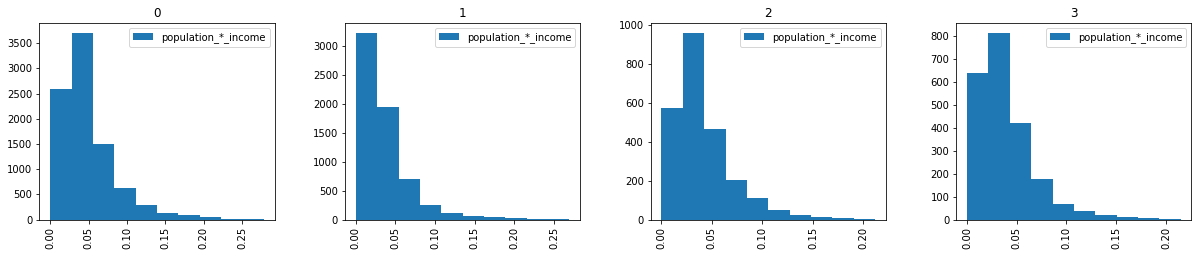

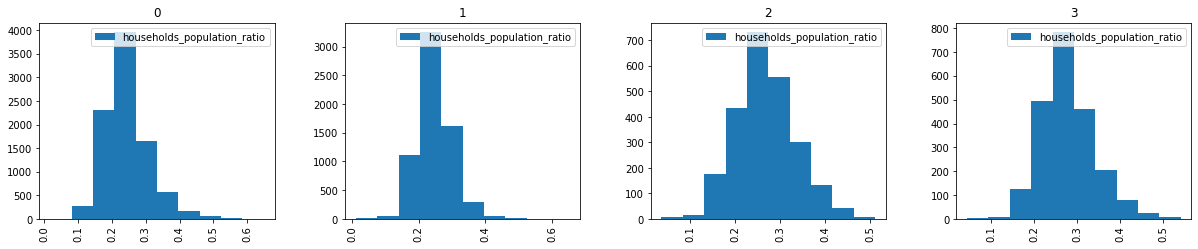

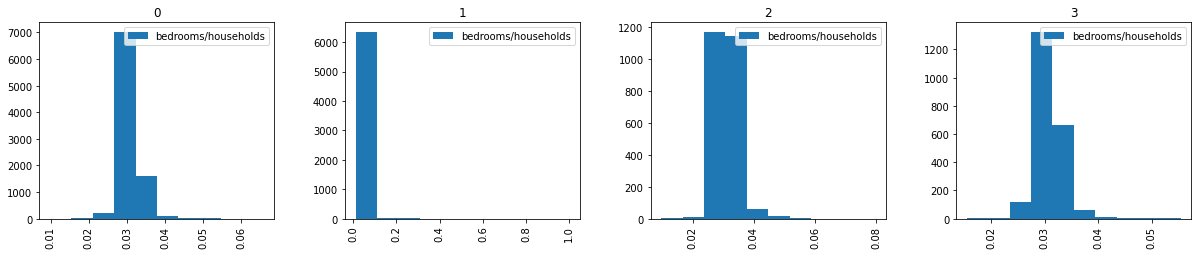

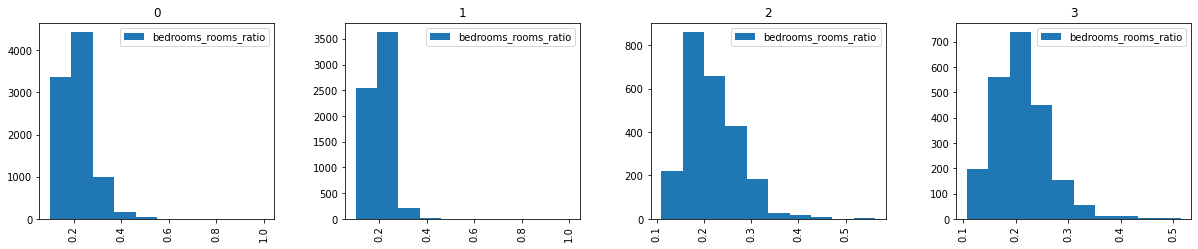

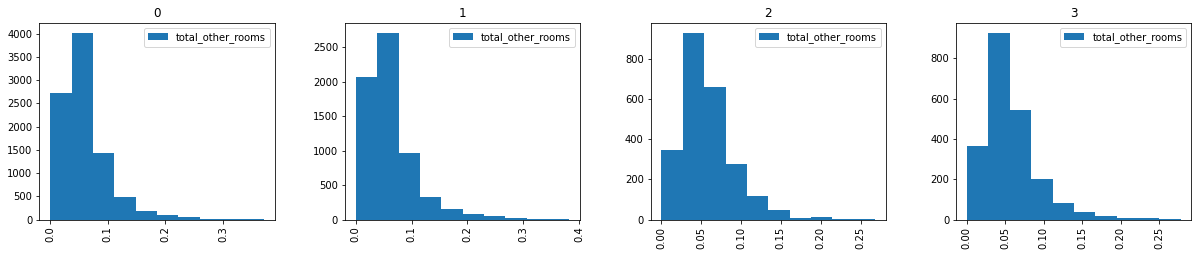

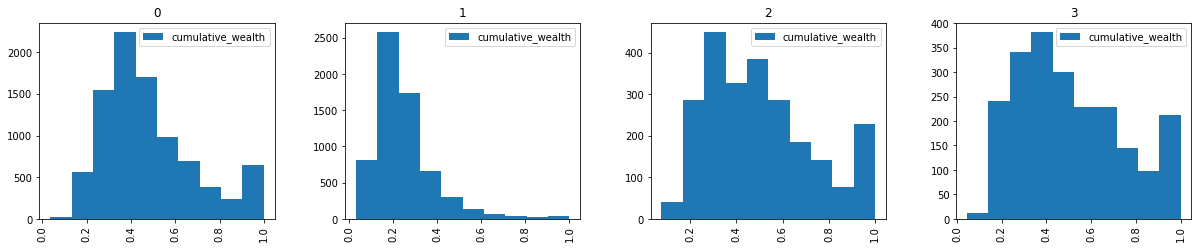

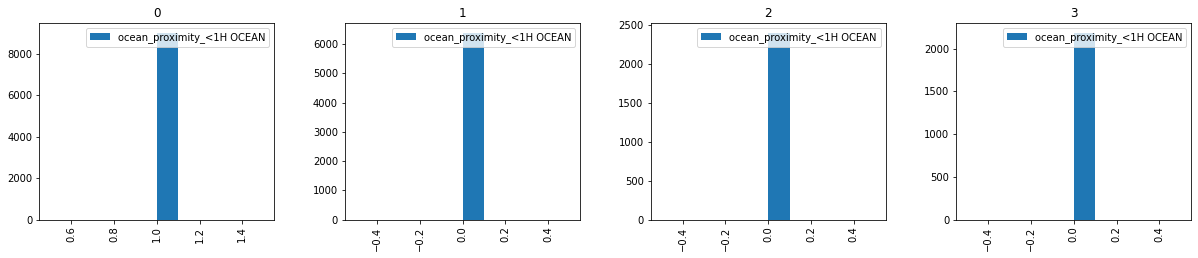

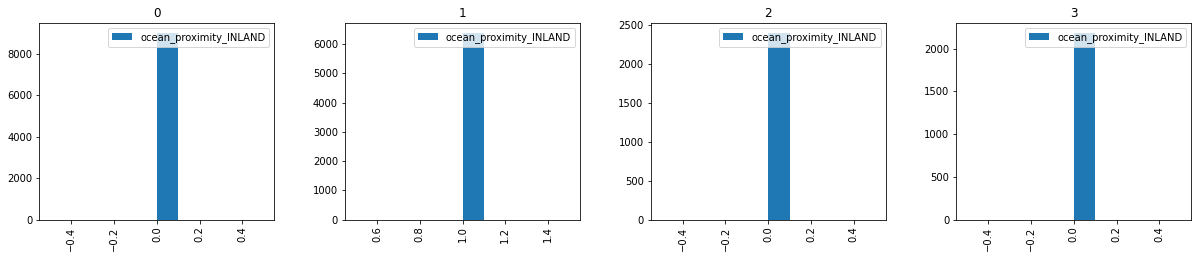

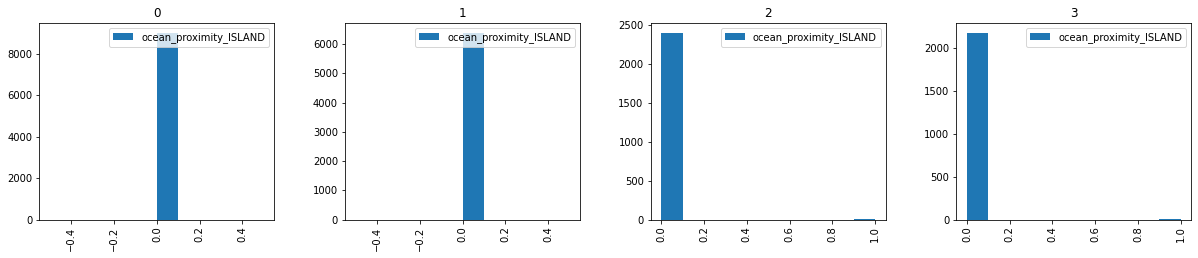

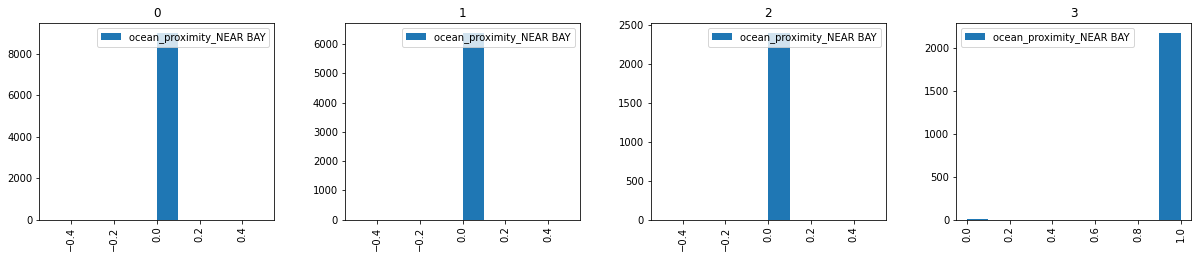

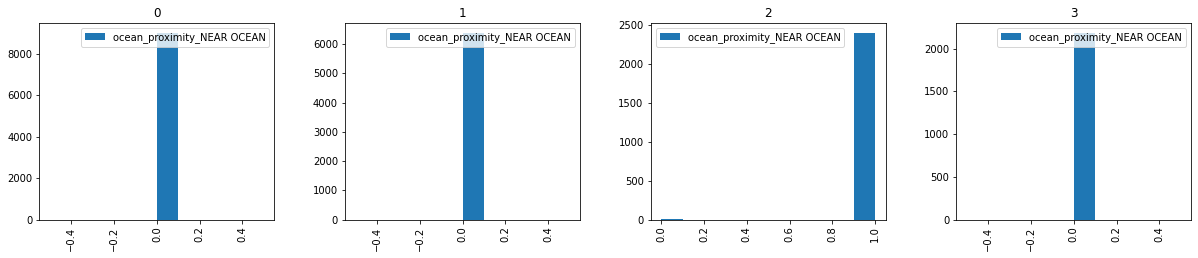

In [ ]:
X_feat['cluster'] = kmeanModel.labels_
X_feat.head(5)

cols = list(X_feat.columns)
cols.remove('cluster')

for col in cols:
  X_feat[col].hist(by=X_feat['cluster'], layout=[4,4], figsize=(20,20), legend=True)


**Some statistics**

In [ ]:
X_feat['cluster'] = kmeanModel.labels_
cols = ['bedrooms/households', 'bedrooms_rooms_ratio', 'total_other_rooms', 'cluster' ]
X_rooms_info = X_feat[cols]
X_rooms_info.groupby('cluster').describe()

bedrooms/households                      ... total_other_rooms                    
                      count      mean       std  ...               50%       75%       max
cluster                                          ...                                      
0                    9011.0  0.030773  0.002658  ...          0.049743  0.074404  0.370976
1                    6401.0  0.033812  0.018756  ...          0.051102  0.076986  0.382785
2                    2405.0  0.031204  0.003289  ...          0.051888  0.072395  0.268257
3                    2189.0  0.030843  0.002668  ...          0.049260  0.070704  0.277922

[4 rows x 24 columns]

Features regarding rooms and bedrooms have very similar statistics in the clusters, they are distributed in a very similar way: the shape of the house does not impact the cluster division. As future works we may want to increase the impacts of those features, combining them in some other ways.

**RESULTS**

After our cluster analysis, we interpreted the clusters as follows:

*   **cluster 1:** houses that are not too old neither too recent, in a middle wealth state, mostly located < 1 from the ocean,
*   **cluster 2:** mostly recent houses, more "poor" than the others, mostly inland;
*   **cluster 3:** houses with a quite good wealth state, moslty located on island or near the ocean 
*   **cluster 4:** mostly old houses, wealthy, located on islands or near a bay



